<a href="https://colab.research.google.com/github/joshiyogendra/racket_classifier_fastai/blob/master/Racket_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Racket Identifier

Leveraging fast.ai Lesson 1 and further lesson learnings

## Initial Setup

In [0]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *

In [3]:
#Connecting Google Drive to Google Collab
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
#Loading the right folder to work with
cd "/content/gdrive/My Drive/AIML/Racket_Classifier"

/content/gdrive/My Drive/AIML/Racket_Classifier


## Getting Images

This is done using [Fatkun Image Downloader](https://chrome.google.com/webstore/detail/fatkun-batch-download-ima/nnjjahlikiabnchcpehcpkdeckfgnohf) Chrome extension


In [0]:
#Defining our classes
classes = ['badminton','tennis','table_tennis']

In [0]:
path = Path('data')

Three separate URL files downloaded

In [0]:
folder = 'badminton'
file = 'badminton.txt'

In [0]:
folder = 'tennis'
file = 'tennis.txt'

In [0]:
folder = 'table_tennis'
file = 'table_tennis.txt'

Need to run the code block below by running the folder / file code one at a time

In [0]:
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [0]:
#at this stage three folders should exist under data folder
path.ls()

[PosixPath('data/table_tennis'),
 PosixPath('data/badminton'),
 PosixPath('data/tennis'),
 PosixPath('data/tennis.txt'),
 PosixPath('data/table_tennis.txt'),
 PosixPath('data/badminton.txt'),
 PosixPath('data/table-tennis')]

Now copy the three URL files into the data folder

In [0]:
#at this stage three folders should exist under data folder and also the three txt files with URLs to download images
path.ls()

[PosixPath('data/badminton.txt'),
 PosixPath('data/tennis.txt'),
 PosixPath('data/table_tennis.txt'),
 PosixPath('data/badminton'),
 PosixPath('data/tennis'),
 PosixPath('data/table_tennis')]

Need to run following code once for each class (by calling the folder / file code above first)

In [0]:
dest = path/folder
download_images(path/file, dest, max_pics=500)

In [0]:
path.ls()

[PosixPath('data/badminton'),
 PosixPath('data/tennis'),
 PosixPath('data/badminton.txt'),
 PosixPath('data/tennis.txt'),
 PosixPath('data/table_tennis.txt'),
 PosixPath('data/table_tennis')]

Once you have all the images dowlnoaded into the folders, call below code to clean up all the files that are not really images.

In [0]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=1000)

## Create ImageDataBunch

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.3,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [8]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['badminton', 'table_tennis', 'tennis'], 3, 759, 325)

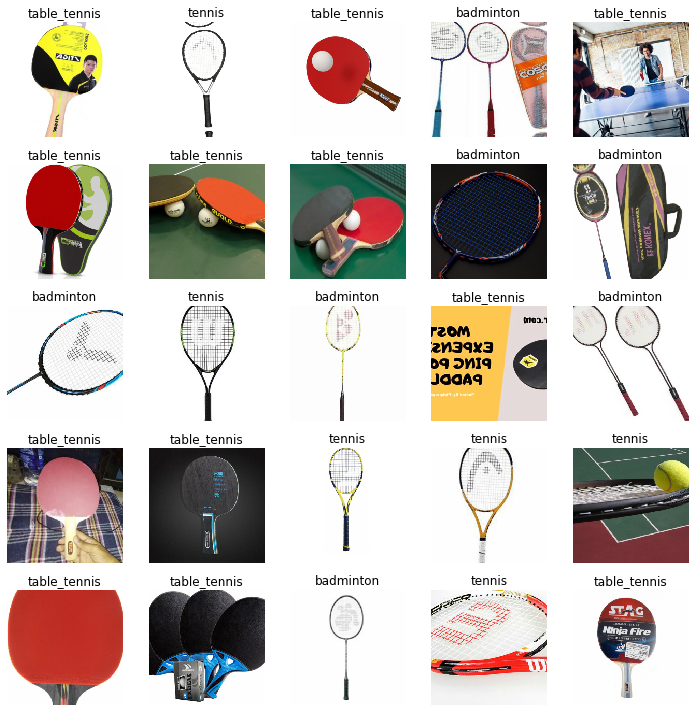

In [9]:
data.show_batch(rows=5, figsize=(10,10))

## Start the Learning Process (2 categories)
##Tennis vs Badminton

In [0]:
#Create a image classifier model using resnet30 as pretrained model
# learn = cnn_learner(data, models.resnet34, metrics=accuracy)

In [0]:
#after pretrained model being loaded while creating learner
# learn.fit_one_cycle(4)
#the change is very significant

epoch,train_loss,valid_loss,accuracy,time
0,0.848668,0.425970,0.836449,00:20
1,0.581576,0.341638,0.901869,00:19
2,0.482874,0.387026,0.906542,00:19
3,0.406925,0.358616,0.897196,00:19


In [0]:
# interp = ClassificationInterpretation.from_learner(learn)

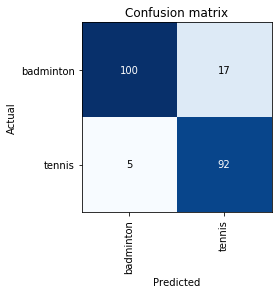

In [0]:
# interp.plot_confusion_matrix()

## Start the Learning Process (3 categories)

In [10]:
#Create a image classifier model using resnet30 as pretrained model
learn = cnn_learner(data, models.resnet34, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:02<00:00, 30.6MB/s]


In [11]:
#after pretrained model being loaded while creating learner
learn.fit_one_cycle(4)
#the change is very significant

epoch,train_loss,valid_loss,accuracy,time
0,1.339076,0.222102,0.929231,02:01
1,0.787434,0.206192,0.935385,00:29
2,0.557761,0.178900,0.938462,00:28
3,0.433102,0.174596,0.935385,00:28


In [0]:
learn.save('stage-1')

## Confusion Matrix

In [0]:
learn.load('stage-1');

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

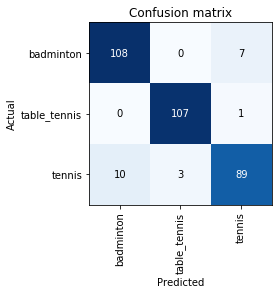

In [15]:
interp.plot_confusion_matrix()

Looks like it has learnt the Table Tennis rackets very well and is not confusing it with badminton / tennis much (considering short handle and no mesh).
It continues to be a bit confused with tennis and badminton.


## Visualizing the confusion

### Importing the code for visualizing the confused items
Code by muellerzr Zachary Mueller https://github.com/muellerzr/ClassConfusion

In [0]:
import math
import pandas as pd
import re
import matplotlib.pyplot as plt
from tqdm import tqdm

from itertools import permutations
from fastai.train import ClassificationInterpretation
from google.colab import widgets

class ClassConfusion():
    "Plot the most confused datapoints and statistics for the models misses." 
    def __init__(self, interp:ClassificationInterpretation, classlist:list, 
               is_ordered:bool=False, cut_off:int=100, varlist:list=None,
               figsize:tuple=(8,8)):
        self.interp = interp
        self._is_tab = (str(type(interp.learn.data)) == "<class 'fastai.tabular.data.TabularDataBunch'>")
        if self._is_tab:
            if interp.learn.data.train_ds.x.cont_names != []: 
                for x in range(len(interp.learn.data.procs)):
                      if "Normalize" in str(interp.learn.data.procs[x]):
                            self.means = interp.learn.data.train_ds.x.processor[0].procs[x].means
                            self.stds = interp.learn.data.train_ds.x.processor[0].procs[x].stds
        self.is_ordered = is_ordered
        self.cut_off = cut_off
        self.figsize = figsize
        self.classl = classlist
        self.varlist = varlist
        self._show_losses(classlist)            

    def _show_losses(self, classl:list, **kwargs):
        "Checks if the model is for Tabular or Images and gathers top losses"
        _, self.tl_idx = self.interp.top_losses(len(self.interp.losses))
        self._tab_losses() if self._is_tab else self._create_tabs()
        
    def _create_tabs(self):
        "Creates a tab for each variable"
        self.lis = self.classl if self.is_ordered else list(permutations(self.classl, 2))
        if self._is_tab:
            self._boxes = len(self.df_list)
            self._cols = math.ceil(math.sqrt(self._boxes))
            self._rows = math.ceil(self._boxes/self._cols)
            self.tbnames = list(self.df_list[0].columns)[:-1] if self.varlist is None else self.varlist
        else:
            vals = self.interp.most_confused()
            self._ranges = []
            self.tbnames = []
            self._boxes = int(input('Please enter a value for `k`, or the top images you will see: '))
            for x in iter(vals):
                for y in range(len(self.lis)):
                    if x[0:2] == self.lis[y]:
                        self._ranges.append(x[2])
                        self.tbnames.append(str(x[0] + ' | ' + x[1]))

        self.tb = widgets.TabBar(self.tbnames)
        self._populate_tabs()
        
    def _populate_tabs(self):
        "Adds relevant graphs to each tab"
        with tqdm(total=len(self.tbnames)) as pbar:
            for i, tab in enumerate(self.tbnames):
                with self.tb.output_to(i):
                    self._plot_tab(tab) if self._is_tab else self._plot_imgs(tab, i)
            pbar.update(1)

    def _plot_imgs(self, tab:str, i:int ,**kwargs):
        "Plots the most confused images"
        classes_gnd = self.interp.data.classes
        x = 0
        if self._ranges[i] < self._boxes:
            cols = math.ceil(math.sqrt(self._ranges[i]))
            rows = math.ceil(self._ranges[i]/cols)

        if self._ranges[i] < 4 or self._boxes < 4:
            cols = 2
            rows = 2
        else:
            cols = math.ceil(math.sqrt(self._boxes))
            rows = math.ceil(self._boxes/cols)
        fig, ax = plt.subplots(rows, cols, figsize=self.figsize)

        [axi.set_axis_off() for axi in ax.ravel()]
        for j, idx in enumerate(self.tl_idx):
            if self._boxes < x+1 or x > self._ranges[i]:
                break
            da, cl = self.interp.data.dl(self.interp.ds_type).dataset[idx]
            row = (int)(x / cols)
            col = x % cols

            ix = int(cl)
            if str(cl) == tab.split(' ')[0] and str(classes_gnd[self.interp.pred_class[idx]]) == tab.split(' ')[2]:
                img, lbl = self.interp.data.valid_ds[idx]
                fn = self.interp.data.valid_ds.x.items[idx]
                #fn = re.search('([^/*]+)_\d+.*$', str(fn)).group(0)
                img.show(ax=ax[row, col])
                ax[row,col].set_title(fn)
                x += 1
        plt.show(fig)
        plt.tight_layout()

    def _plot_tab(self, tab:str):
        "Generates graphs"
        if self._boxes is not None:
            fig, ax = plt.subplots(self._boxes, figsize=self.figsize)
        else:
            fig, ax = plt.subplots(self._cols, self._rows, figsize=self.figsize)
        fig.subplots_adjust(hspace=.5)
        for j, x in enumerate(self.df_list):
            title = f'{"".join(x.columns[-1])} {tab} distribution'
            if self._boxes is None:
                row = int(j / self._cols)
                col = j % row
            if tab in self.cat_names:
                vals = pd.value_counts(x[tab].values)
                if self._boxes is not None:
                    if vals.nunique() < 10:
                        fig = vals.plot(kind='bar', title=title,  ax=ax[j], rot=0, width=.75)
                    elif vals.nunique() > self.cut_off:
                        print(f'Number of values is above {self.cut_off}')
                    else:
                        fig = vals.plot(kind='barh', title=title,  ax=ax[j], width=.75)   
                else:
                    fig = vals.plot(kind='barh', title=title,  ax=ax[row, col], width=.75)
            else:
                vals = x[tab]
                if self._boxes is not None:
                    axs = vals.plot(kind='hist', ax=ax[j], title=title, y='Frequency')
                else:
                    axs = vals.plot(kind='hist', ax=ax[row, col], title=title, y='Frequency')
                axs.set_ylabel('Frequency')
                if len(set(vals)) > 1:
                    vals.plot(kind='kde', ax=axs, title=title, secondary_y=True)
                else:
                    print('Less than two unique values, cannot graph the KDE')
        plt.show(fig)
        plt.tight_layout()
        
    def _tab_losses(self, **kwargs):
        "Gathers dataframes of the combinations data"
        classes = self.interp.data.classes
        cat_names = self.interp.data.x.cat_names
        cont_names = self.interp.data.x.cont_names
        comb = self.classl if self.is_ordered else list(permutations(self.classl,2))

        self.df_list = []
        arr = []
        for i, idx in enumerate(self.tl_idx):
            da, _ = self.interp.data.dl(self.interp.ds_type).dataset[idx]
            res = ''
            for c, n in zip(da.cats, da.names[:len(da.cats)]):
                string = f'{da.classes[n][c]}'
                if string == 'True' or string == 'False':
                    string += ';'
                    res += string

                else:
                    string = string[1:]
                    res += string + ';'
            for c, n in zip(da.conts, da.names[len(da.cats):]):
                res += f'{c:.4f};'
            arr.append(res)
        f = pd.DataFrame([ x.split(';')[:-1] for x in arr], columns=da.names)
        for i, var in enumerate(self.interp.data.cont_names):
            f[var] = f[var].apply(lambda x: float(x) * self.stds[var] + self.means[var])
        f['Original'] = 'Original'
        self.df_list.append(f)

        for j, x in enumerate(comb):
            arr = []
            for i, idx in enumerate(self.tl_idx):
                da, cl = self.interp.data.dl(self.interp.ds_type).dataset[idx]
                cl = int(cl)

                if classes[self.interp.pred_class[idx]] == comb[j][0] and classes[cl] == comb[j][1]:
                    res = ''
                    for c, n in zip(da.cats, da.names[:len(da.cats)]):
                        string = f'{da.classes[n][c]}'
                        if string == 'True' or string == 'False':
                            string += ';'
                            res += string
                        else:
                            string = string[1:]
                            res += string + ';'
                    for c, n in zip(da.conts, da.names[len(da.cats):]):
                        res += f'{c:.4f};'
                    arr.append(res)      
            f = pd.DataFrame([ x.split(';')[:-1] for x in arr], columns=da.names)
            for i, var in enumerate(self.interp.data.cont_names):
                f[var] = f[var].apply(lambda x: float(x) * self.stds[var] + self.means[var])
            f[str(x)] = str(x)
            self.df_list.append(f)
        self.cat_names = cat_names
        self._create_tabs() 

### now looking at the content of confused items

Please enter a value for `k`, or the top images you will see: 3


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  0%|          | 0/4 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

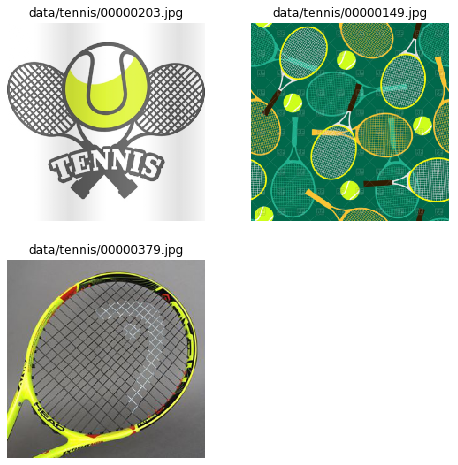

<Figure size 432x288 with 0 Axes>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

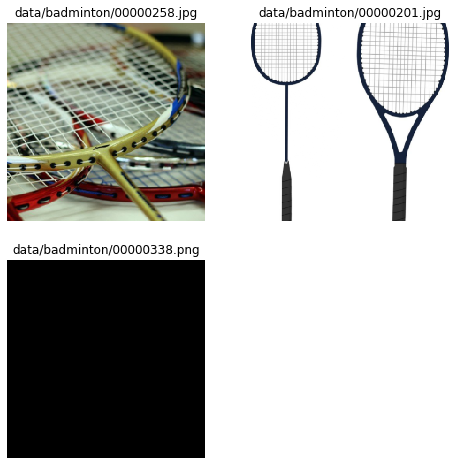

<Figure size 432x288 with 0 Axes>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

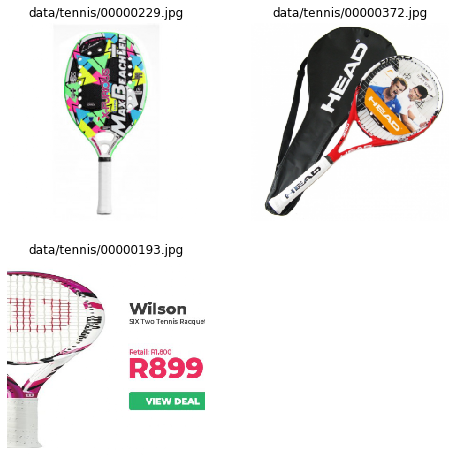

<Figure size 432x288 with 0 Axes>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

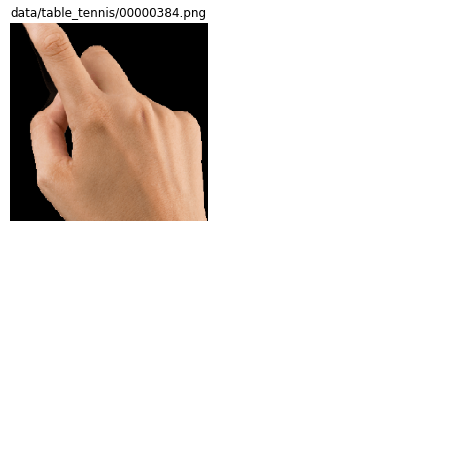

<Figure size 432x288 with 0 Axes>

<IPython.core.display.Javascript object>

 25%|██▌       | 1/4 [00:11<00:33, 11.26s/it]


In [17]:
ClassConfusion(interp, classes)

## Unfreezing Layers and finding Learning Rate

In [0]:
learn.unfreeze()

In [19]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


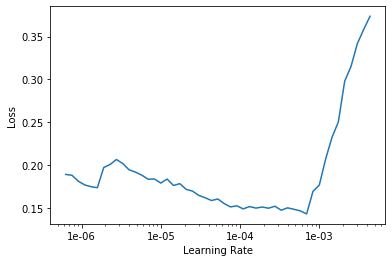

In [20]:
# If the plot is not showing try to give a start and end learning rate
# learn.lr_find(start_lr=1e-5, end_lr=1e-1)
learn.recorder.plot()

In [0]:
lr = 2.6e-4


In [22]:
learn.fit_one_cycle(10, max_lr=lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.131289,0.149552,0.950769,00:29
1,0.124247,0.180389,0.935385,00:29
2,0.109206,0.567482,0.892308,00:29
3,0.118396,0.829633,0.886154,00:29
4,0.117051,0.271894,0.938462,00:29
5,0.112036,0.258330,0.950769,00:29
6,0.113706,0.192435,0.950769,00:29
7,0.103030,0.181238,0.953846,00:29
8,0.085378,0.167613,0.956923,00:29
9,0.074296,0.158234,0.950769,00:29


In [0]:
learn.save('stage-2')

### Confusion Matrix with new model

In [0]:
learn.load('stage-2');

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

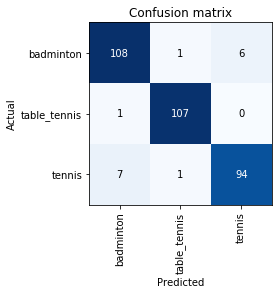

In [26]:
interp.plot_confusion_matrix()

Please enter a value for `k`, or the top images you will see: 5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  0%|          | 0/5 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

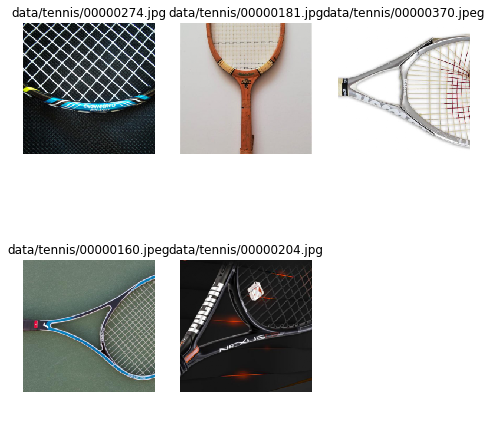

<Figure size 432x288 with 0 Axes>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

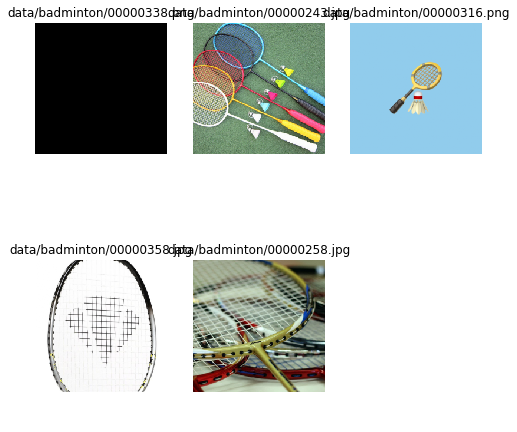

<Figure size 432x288 with 0 Axes>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

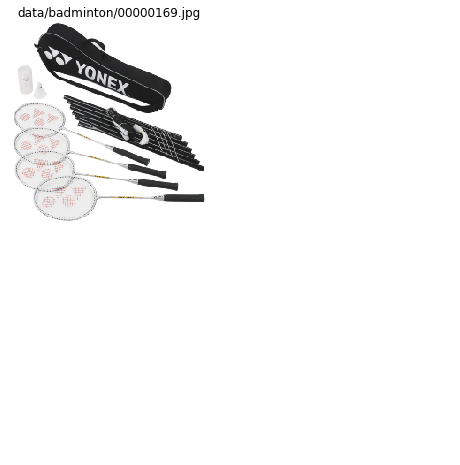

<Figure size 432x288 with 0 Axes>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

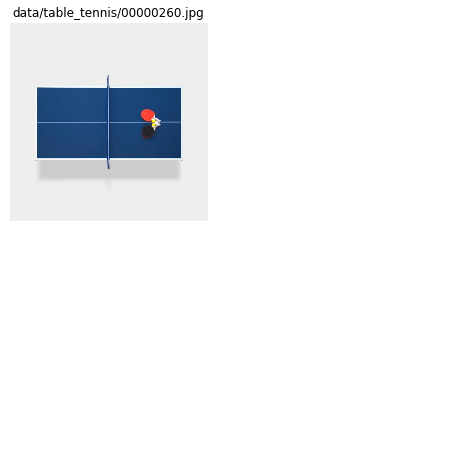

<Figure size 432x288 with 0 Axes>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

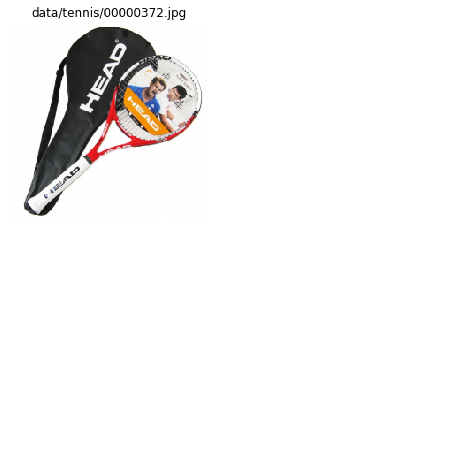

<Figure size 432x288 with 0 Axes>

<IPython.core.display.Javascript object>

 20%|██        | 1/5 [00:28<01:54, 28.68s/it]


In [27]:
ClassConfusion(interp, classes)

# Testing

## Putting model in Production

In [0]:
learn.export()

In [0]:
defaults.device = torch.device('cpu')

In [0]:
learn = load_learner(path)

In [67]:
#setting test path
path_test = Path('data/Testing')
path_test.ls()

[PosixPath('data/Testing/ten_racket_2.jpg'),
 PosixPath('data/Testing/ten_racket_1.jpg'),
 PosixPath('data/Testing/bad_racket_2.jpeg'),
 PosixPath('data/Testing/bad_racket_1.jpeg'),
 PosixPath('data/Testing/bad_racket_3.jpg'),
 PosixPath('data/Testing/tt_racket_1.jpg'),
 PosixPath('data/Testing/tt_racket_2.jpg'),
 PosixPath('data/Testing/tt_racket_3.jpg')]

## Prediction

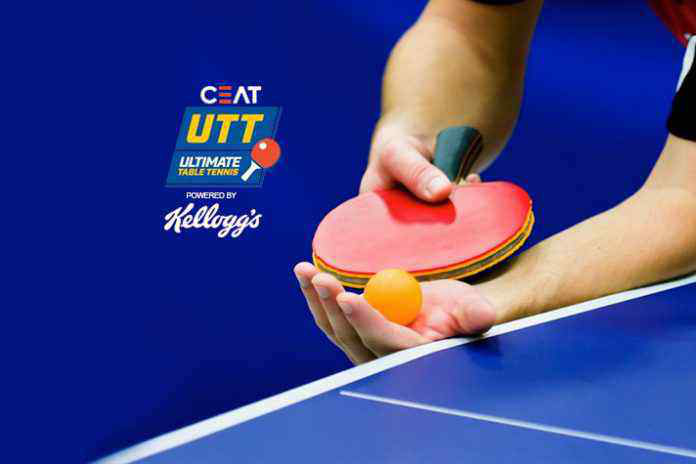

In [70]:
img = open_image(path_test/'tt_racket_3.jpg',)
img

In [71]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class, data.classes, outputs

(Category table_tennis,
 ['badminton', 'table_tennis', 'tennis'],
 tensor([5.0328e-14, 1.0000e+00, 1.1289e-15]))

In [75]:
len(data.train_ds), len(data.valid_ds)

(759, 325)